# **PRÀCTICA 1: Identificació d'idioma**

# Main program

## Setup

First, we import the required libraries.

In [1]:
import math
import json
from typing import Callable
from functions import *
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Reading the outputs from the training phase.

In [2]:
# Load trigrams and unique characters from json files
def dict_string_to_trigramtuple(d: dict) -> dict:
    return {key: {tuple(k): v for k, v in value.items()} for key, value in d.items()}

def refactor_validation(d: dict) -> dict:
    return {key: ({tuple(k2): v2 for k2, v2 in value[0].items()}, value[1]) for key, value in d.items()}

def refactor_test(d: dict) -> dict:
    return  {key: [[(tuple(k), v) for k, v in value.items()] for value in values] for key, values in d.items()}

# Load train model
trigrams = dict_string_to_trigramtuple(json.load(open('./weights/trigrams.json')))
unique_chars = json.load(open('./weights/unique_chars.json'))

# Calculate the number of unique trigrams
unique_trigrams = set()
for k in trigrams.keys():
    unique_trigrams.update(set(trigrams[k].keys()))

# Load preprocessed data (train and test)
train = json.load(open('./preprocessed_langId/train.json'))
test = json.load(open('./preprocessed_langId/test.json'))

# Load validation model
validation_trigrams = refactor_validation(json.load(open('./weights/validation_trigrams.json')))
validation_unique = json.load(open('./weights/validation_unique_chars.json'))

# Load test and validation test trigram counts
pre_trigrams = refactor_test(json.load(open('./weights/test.json')))
val_trigrams = refactor_test(json.load(open('./weights/validation_sent.json')))

Calculate the possible B values. Later on, they will be used to test which one is the best.

In [3]:
totals = {key: sum(trigrams[key].values()) for key in trigrams.keys()}

b_value_chars_variable = {key: value ** 3 for key, value in unique_chars.items()} # b value for unique characters. Different for each language
b_value_max_chars = max(b_value_chars_variable.values()) # Max b value for unique characters. Same for all languages
b_value_min_chars = min(b_value_chars_variable.values()) # Min b value for unique characters. Same for all languages
b_value_mean_chars = int(round(np.mean(list(unique_chars.values())))) ** 3 # Mean b value for unique characters. Same for all languages
b_value_theoretical_chars = 26 ** 3 # Theoretical b value (number of unique trigrams in the alphabet). Same for all languages

b_value_total_observed_tri = len(unique_trigrams) # Total observed trigrams. Same for all languages
b_value_observed_tri_language = {key: len(trigrams[key]) + 500 for key in trigrams.keys()} # Total observed trigrams per language. Different for each language

b_values = {'max. unique chars': {key: b_value_max_chars for key in unique_chars.keys()}, 
			'mean unique chars': {key: b_value_mean_chars for key in unique_chars.keys()}, 
			'min. unique chars': {key: b_value_min_chars for key in unique_chars.keys()},
			'variable unique chars': b_value_chars_variable,
			'theoretical unique chars': {key: b_value_theoretical_chars for key in unique_chars.keys()},
			'total observed trigrams': {key: b_value_total_observed_tri for key in unique_chars.keys()},
			'observed trigrams per language': b_value_observed_tri_language}

print('Variable unique chars b value:', b_value_chars_variable)
print('Max unique chars b value:', b_value_max_chars, math.cbrt(b_value_max_chars))
print('Mean unique chars b value:', b_value_mean_chars, math.cbrt(b_value_mean_chars))
print('Min unique chars b value:', b_value_min_chars, math.cbrt(b_value_min_chars))
print('Theoretical unique chars b value:', b_value_theoretical_chars, math.cbrt(b_value_theoretical_chars))
print('Total observed trigrams b value:', b_value_total_observed_tri)
print('Observed trigrams per language b value:', b_value_observed_tri_language)

Variable unique chars b value: {'deu': 357911, 'eng': 205379, 'fra': 592704, 'ita': 493039, 'nld': 493039, 'spa': 405224}
Max unique chars b value: 592704 84.0
Mean unique chars b value: 405224 74.0
Min unique chars b value: 205379 59.0
Theoretical unique chars b value: 17576 26.0
Total observed trigrams b value: 21773
Observed trigrams per language b value: {'deu': 11821, 'eng': 9890, 'fra': 10921, 'ita': 8825, 'nld': 10648, 'spa': 9794}


Small testing cell to reassure that the model is loaded properly.

In [4]:
# Test the Lidstone smoothing
text = '  Prueba de ejemplo  '
probs = []
languages = {"deu": "Deutsch (German)", 
             "eng": "English (English)", 
             "fra": "Français (French)", 
             "ita": "Italiano (Italian)", 
             "spa": "Español (Spanish)", 
             "nld": "Nederlands (Dutch)"} # Dictionary with all the languages and their abreviations.

total_trigrams = {key: sum(dicts.values()) for key, dicts in trigrams.items()}
trigram_finder = TrigramCollocationFinder.from_words(text)

# Find the probabilities of each language
for language in trigrams.keys():
    prob = probs_total(b_value=b_values['mean unique chars'][language], trigram_finder=trigram_finder, model=trigrams[language], total_trigrams=total_trigrams[language], smooth=absolute_discounting, param=0.1,)
    probs.append((language, prob))

#Get the highest probability
max_probs = max(probs, key = lambda x: x[1])
print(max_probs)
probs = sorted(probs, key = lambda x: x[1], reverse=True)

# Normalize the probabilities and print the results
exp = [math.exp(p[1] - max_probs[1]) for p in probs]
normalize = [(e / sum (exp))*100 for e in exp]
lang = [languages[p[0]] for p in probs]
for e in range(len(lang)):
    print(f"{lang[e]}: {normalize[e]}")

('spa', -197.42270079881035)
Español (Spanish): 100.0
Nederlands (Dutch): 1.5080892062141594e-15
English (English): 2.9069290041715445e-16
Français (French): 1.2378441572587357e-16
Deutsch (German): 1.0664624625091374e-17
Italiano (Italian): 2.2658953418965508e-26


## Validation

After executing the setup cells and being sure that the model is well loaded, we can start to do the validation. In this next cell we define a function that will help us reduce the execution times and is also going to be used in test.

In [ ]:
# Calculate the probabilities for each trigram. Returns a dict.
def create_prob_dict(b_value_dict: dict = b_values['mean unique chars'], smooth: Callable = lidstone_smooth, param: float = 0.5, model: dict = trigrams, total: dict = totals, unique: set = unique_trigrams) -> dict:
    d = {}
    for lang in languages.keys():
        probab = {tri: math.log(smooth(param, trigram=tri, b_value=b_value_dict[lang], trigram_counts=model[lang], total_trigrams=total[lang])) for tri in unique}
        
        # Probabilities of the trigrams that do no appear
        probab["None"] = math.log(smooth(param, trigram=(1,1,1), b_value=b_value_dict[lang], trigram_counts=model[lang], total_trigrams=total[lang]))
        d[lang] = probab
    return d

To do the validation, we need to split the validation "train" (the model) and the validation "test" (the sentences).

In [6]:
val_train = {key: value[0] for key, value in validation_trigrams.items()}
val_test = {key: value[1] for key, value in validation_trigrams.items()}

We define a function that will be the one that, given a set of parameters, returns the errors. It uses the prob_dict from before, and a similar structure to probs_total.

In [35]:
def accuracy_validation(smooth: Callable = lidstone_smooth, param: float = 0.5, b_value_dict: dict = b_values) -> list:
    validation_errors = []
    totals_val = {key: sum(val_train[key].values()) for key in val_train.keys()}
    probabilities = create_prob_dict(b_value_dict=b_value_dict, smooth=smooth, param=param, model=val_train, total=totals_val, unique=unique_trigrams)
    for lang in languages.keys():
        for sentence in val_trigrams[lang]:
            probs = []
            for ling in languages.keys():
                prob = 0
                for trigram, num_instances in sentence:
                    prob += num_instances * probabilities[ling].get(trigram, probabilities[ling]["None"])
                probs.append((ling, prob))
            max_prob = max(probs, key = lambda x: x[1])
            if max_prob[0] != lang:
                validation_errors.append({"text": sentence, "true": lang, "pred": max_prob[0]})
    return validation_errors

Having defined all the functions, we can now do the validation. We specify some parameters to test and we iterate through all the possible combinations. The results are stored in dictionaries.

In [8]:
# Smoothing functions and parameters to try
smoothing_functions = [lidstone_smooth, linear_discounting, absolute_discounting]
alphas = [0.001, 0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.9]

i = 0
total_iterations = len(smoothing_functions) * len(alphas) * len(b_values.keys())
validation_results_dict = {}

x_values = {b_key: {func.__name__: [] for func in smoothing_functions} for b_key in b_values.keys()}
y_values = {b_key: {func.__name__: [] for func in smoothing_functions} for b_key in b_values.keys()}

# Iterate through possible b values, functions and parameters and save the errors.
for b_key in b_values.keys():
    for func in smoothing_functions:
        for alpha in alphas:
            i += 1
            print(f"Validation progress: {round(i*100/total_iterations, 2)}%   ", end="\r")
            err = accuracy_validation(smooth=func, param=alpha, b_value_dict=b_values[b_key])

            validation_results_dict[i] = {
                "errors": err, 
                "alpha": alpha, 
                "smoothing": func.__name__, 
                "b_value": b_key
            }
            
            x_values[b_key][func.__name__].append(alpha)
            y_values[b_key][func.__name__].append(len(err))

To visualize the results, execute the next cell. It makes a plot for each b value, with the results of the different smothing functions and parameters.

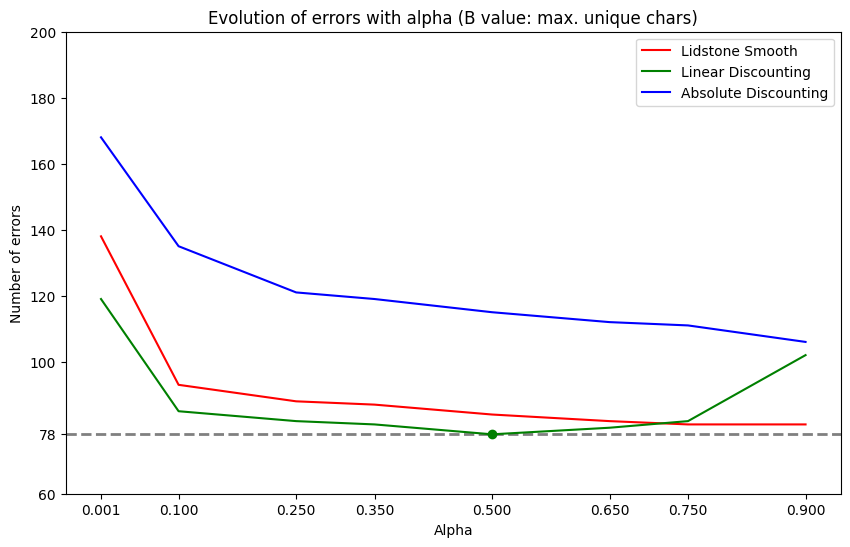

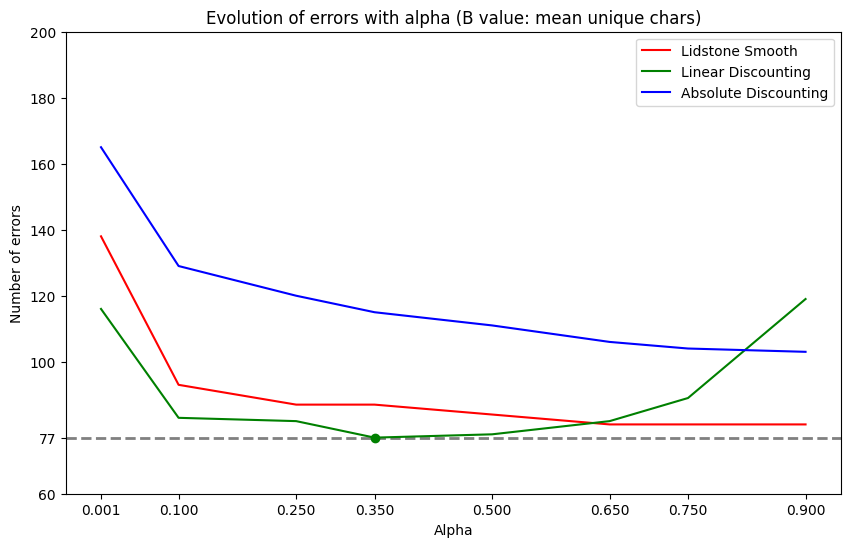

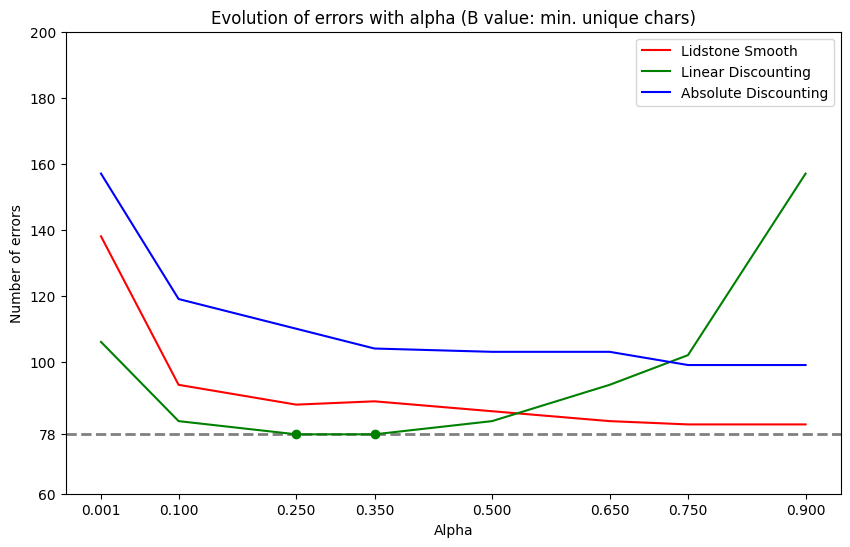

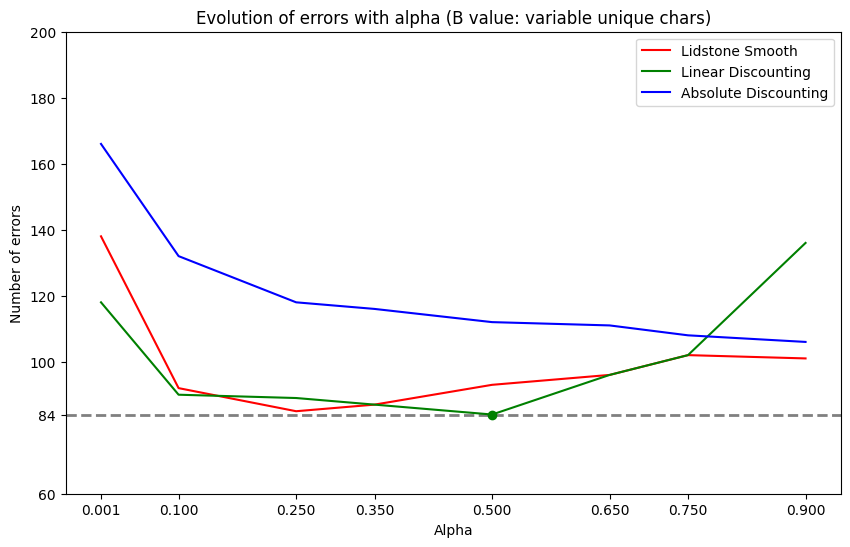

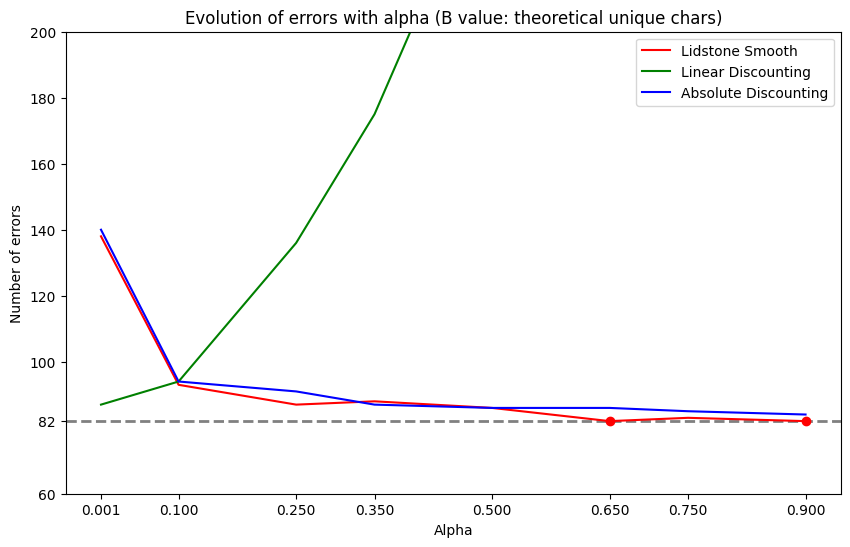

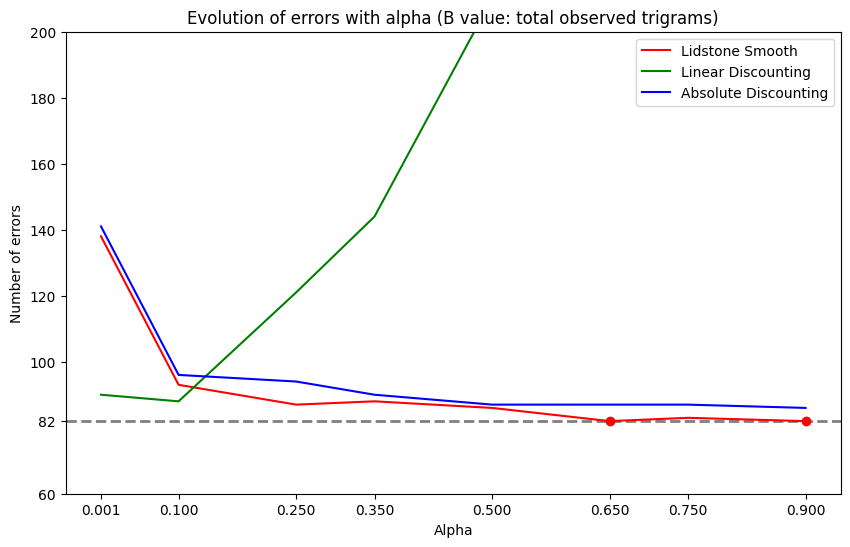

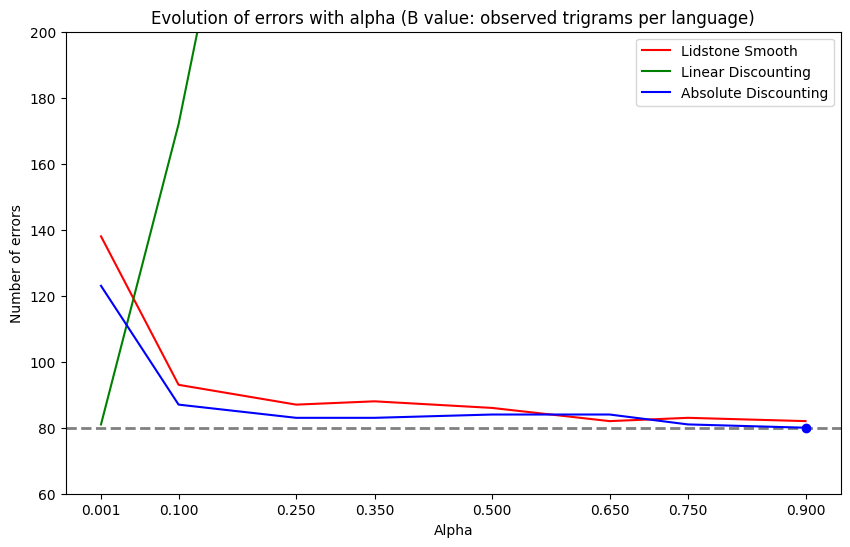

VALIDATION RESULTS:
Smoothing: linear_discounting, B value: mean unique chars, Alpha: 0.35, Errors: 77
Smoothing: linear_discounting, B value: max. unique chars, Alpha: 0.5, Errors: 78
Smoothing: linear_discounting, B value: mean unique chars, Alpha: 0.5, Errors: 78
Smoothing: linear_discounting, B value: min. unique chars, Alpha: 0.25, Errors: 78
Smoothing: linear_discounting, B value: min. unique chars, Alpha: 0.35, Errors: 78
Smoothing: linear_discounting, B value: max. unique chars, Alpha: 0.65, Errors: 80
Smoothing: absolute_discounting, B value: observed trigrams per language, Alpha: 0.9, Errors: 80
Smoothing: lidstone_smooth, B value: max. unique chars, Alpha: 0.75, Errors: 81
Smoothing: lidstone_smooth, B value: max. unique chars, Alpha: 0.9, Errors: 81
Smoothing: linear_discounting, B value: max. unique chars, Alpha: 0.35, Errors: 81
Smoothing: lidstone_smooth, B value: mean unique chars, Alpha: 0.65, Errors: 81
Smoothing: lidstone_smooth, B value: mean unique chars, Alpha: 0.

In [23]:
# Plots to show the evolution of errors with alpha
for b_key in b_values.keys():
    plt.figure(figsize=(10, 6))

    # Plot the minimum number of errors (mark all the minimums with a black dot)
    min_errors = min(y_values[b_key][lidstone_smooth.__name__] + y_values[b_key][linear_discounting.__name__] + y_values[b_key][absolute_discounting.__name__])

    plt.axhline(y=min_errors, color='grey', linestyle='--', linewidth=2, zorder=1) # Add a horizontal line to mark the minimum number of errors

    plt.plot(x_values[b_key][lidstone_smooth.__name__], y_values[b_key][lidstone_smooth.__name__], label="Lidstone Smooth", color='red')
    plt.plot(x_values[b_key][linear_discounting.__name__], y_values[b_key][linear_discounting.__name__], label="Linear Discounting", color='green')
    plt.plot(x_values[b_key][absolute_discounting.__name__], y_values[b_key][absolute_discounting.__name__], label="Absolute Discounting", color='blue')
    
    for i in range(len(x_values[b_key][lidstone_smooth.__name__])):
        if y_values[b_key][lidstone_smooth.__name__][i] == min_errors:
            plt.scatter(x_values[b_key][lidstone_smooth.__name__][i], y_values[b_key][lidstone_smooth.__name__][i], color="red", zorder=3)

    for i in range(len(x_values[b_key][linear_discounting.__name__])):
        if y_values[b_key][linear_discounting.__name__][i] == min_errors:
            plt.scatter(x_values[b_key][linear_discounting.__name__][i], y_values[b_key][linear_discounting.__name__][i], color="green", zorder=3)

    for i in range(len(x_values[b_key][absolute_discounting.__name__])):
        if y_values[b_key][absolute_discounting.__name__][i] == min_errors:
            plt.scatter(x_values[b_key][absolute_discounting.__name__][i], y_values[b_key][absolute_discounting.__name__][i], color="blue", zorder=3)

    plt.title(f'Evolution of errors with alpha (B value: {b_key})')
    plt.xlabel('Alpha')
    plt.xticks(alphas)
    plt.ylim(60, 200) # Limit the y axis to 200 errors to compare the different plots
    plt.yticks([tick for tick in list(plt.yticks()[0]) if abs(tick - min_errors) >= 10] + [min_errors]) # Add the minimum number of errors to the y axis
    plt.ylabel('Number of errors')
    plt.legend()
    plt.savefig(f'./plots/validation_errors_b_{b_key.replace(" ", "_")}.png')
    plt.show()
    plt.close()

# Print the results of the validation sorted by the number of errors
print("VALIDATION RESULTS:")
validation_results_sorted = sorted(validation_results_dict.values(), key = lambda x: len(x["errors"]))
for res in validation_results_sorted:
    print(f"Smoothing: {res['smoothing']}, B value: {res['b_value']}, Alpha: {res['alpha']}, Errors: {len(res['errors'])}")

After this, we can select the values. In our case, linear_discounting, 0.35 and mean unique chars.

## Test

The last step is to execute the model with the test. This next cell does all you need: calculates the errors and does the confusion matrix.

Total errors: 64 out of 59977 sentences.
Total accuracy: 0.9989329242876436
*Accuracy deu: 0.9993993993993994
*Accuracy eng: 0.99969960949234
*Accuracy fra: 0.9989
*Accuracy ita: 0.9986
*Accuracy nld: 0.9979
*Accuracy spa: 0.9991


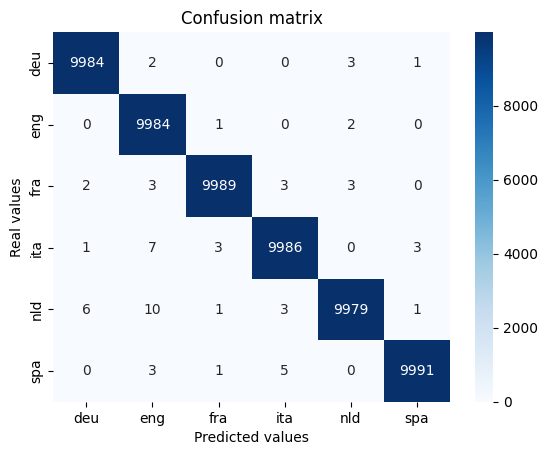

WRONG PREDICTIONS:
*True: deu, Predicted: spa, Text: "   autos wie den dacia sandero. "
*True: deu, Predicted: nld, Text: "   der stoffbeutel war leer. "
*True: deu, Predicted: nld, Text: "   hij was de leider vane groep ie provincie khorasne islamitische staat. "
*True: deu, Predicted: eng, Text: "   jararthomas .jan theorethisch ist es simpel. "
*True: deu, Predicted: eng, Text: "   was ist wicop? "
*True: deu, Predicted: nld, Text: "   wat er nu gebeurt, is heel zwaar voorhem als jonge gast. "
*True: eng, Predicted: nld, Text: "   in asia, japan's nikkei (. "
*True: eng, Predicted: fra, Text: "   internet trouble. "
*True: eng, Predicted: nld, Text: "   vancouver head coach willie desjardins. "
*True: fra, Predicted: nld, Text: "   les anderlechtois devront avat tout museler ruud an nistelrooy. "
*True: fra, Predicted: ita, Text: "   enfin, l'impeccable déroulé de la prestationdes quatre musiciens (rava, tropette, giovanni guidi, piano gabriee eangelit, conrebass, et frizio sferr, b

In [10]:
# Test

# Initialize error list
prediction_errors_list = []
predictions = {language: [] for language in test.keys()}

# Pre calculate the probabilities
prob_dict = create_prob_dict(model=trigrams, b_value_dict=b_values['mean unique chars'], smooth=linear_discounting, param=0.35)

language_list = test.keys()

# Same loop seen in accuracy_validation
for language in language_list:
	for sentence in pre_trigrams[language]:
		probs = []
		for lingua in language_list:
			prob_sec = 0
			for trigram, num_instances in sentence:
				prob_sec += num_instances * prob_dict[lingua].get(trigram, prob_dict[lingua]["None"])
			probs.append((lingua, prob_sec))
		max_prob = max(probs, key = lambda x: x[1])
		predictions[language].append(max_prob[0])
		if max_prob[0] != language:
			sentence = ''.join([t[0][0] for t in sentence]).join(sentence[-1][0][1:])
			prediction_errors_list.append({"text": sentence, "true": language, "pred": max_prob[0]})

# Calculate accuracy
correct_predictions = {language: sum([1 for pred in predictions[language] if pred == language]) for language in test.keys()}
total_accuracy = sum(correct_predictions.values()) / sum([len(value) for value in test.values()])

# Print results
print(f"Total errors: {len(prediction_errors_list)} out of {sum([len(value) for value in test.values()])} sentences.")
print(f"Total accuracy: {total_accuracy}")
for language, correct in correct_predictions.items():
	print(f"*Accuracy {language}: {correct / len(test[language])}")

# Confusion matrix
language_names = [language for language in test.keys()]

cm = confusion_matrix(y_true=[language for language in test.keys() for _ in range(len(test[language]))],
					  y_pred=[pred for language in test.keys() for pred in predictions[language]],
					  labels=language_names)

sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=language_names, yticklabels=language_names, cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.title('Confusion matrix')
plt.savefig('./plots/confusion_matrix.png')
plt.show()
plt.close()

# Print the errors
print("WRONG PREDICTIONS:")
for error in prediction_errors_list:
	print(f"*True: {error['true']}, Predicted: {error['pred']}, Text: \"{error['text']}\"")

Note that the sentences shown aren't de real sentences. Due to the precalculation, we loose information about the order of some trigrams, and the ones that are repeated in a sentence only show the first time.